# Student Performance Regression

* Dataset: https://www.kaggle.com/datasets/devansodariya/student-performance-data/data
* Original data from UCI: https://archive.ics.uci.edu/dataset/320/student+performance

In [1]:
#!pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from math import ceil
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_text
import xgboost as xgb
from sklearn.model_selection import KFold

In [3]:
df = pd.read_csv("student_data.csv")

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
df.columns = df.columns.str.lower()

In [6]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['school',
 'sex',
 'address',
 'famsize',
 'pstatus',
 'mjob',
 'fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [7]:
df.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
pstatus       object
medu           int64
fedu           int64
mjob          object
fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
dalc           int64
walc           int64
health         int64
absences       int64
g1             int64
g2             int64
g3             int64
dtype: object

In [8]:
df.describe()

,age,medu,fedu,traveltime,studytime,failures,famrel,freetime,goout,dalc,walc,health,absences,g1,g2,g3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## 1. Exploratory Data Analysis

In [9]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

school
['GP' 'MS']
2

sex
['F' 'M']
2

age
[18 17 15 16 19]
8

address
['U' 'R']
2

famsize
['GT3' 'LE3']
2

pstatus
['A' 'T']
2

medu
[4 1 3 2 0]
5

fedu
[4 1 2 3 0]
5

mjob
['at_home' 'health' 'other' 'services' 'teacher']
5

fjob
['teacher' 'other' 'services' 'health' 'at_home']
5

reason
['course' 'other' 'home' 'reputation']
4

guardian
['mother' 'father' 'other']
3

traveltime
[2 1 3 4]
4

studytime
[2 3 1 4]
4

failures
[0 3 2 1]
4

schoolsup
['yes' 'no']
2

famsup
['no' 'yes']
2

paid
['no' 'yes']
2

activities
['no' 'yes']
2

nursery
['yes' 'no']
2

higher
['yes' 'no']
2

internet
['no' 'yes']
2

romantic
['no' 'yes']
2

famrel
[4 5 3 1 2]
5

freetime
[3 2 4 1 5]
5

goout
[4 3 2 1 5]
5

dalc
[1 2 5 3 4]
5

walc
[1 3 2 4 5]
5

health
[3 5 1 2 4]
5

absences
[ 6  4 10  2  0]
34

g1
[ 5  7 15  6 12]
17

g2
[ 6  5  8 14 10]
17

g3
[ 6 10 15 11 19]
18



<Axes: xlabel='g3', ylabel='Count'>

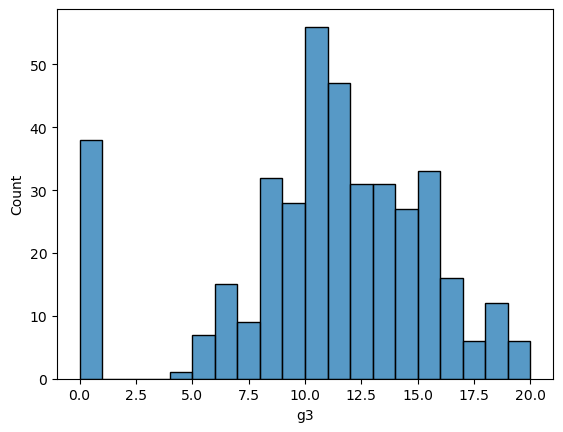

In [10]:
sns.histplot(df.g3, bins=20)

In [11]:
df.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
pstatus       0
medu          0
fedu          0
mjob          0
fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
dalc          0
walc          0
health        0
absences      0
g1            0
g2            0
g3            0
dtype: int64

In [12]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['school',
 'sex',
 'address',
 'famsize',
 'pstatus',
 'mjob',
 'fjob',
 'reason',
 'guardian',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [13]:
numerical = list(df.dtypes[df.dtypes == 'int64'].index)
numerical

['age',
 'medu',
 'fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'dalc',
 'walc',
 'health',
 'absences',
 'g1',
 'g2',
 'g3']

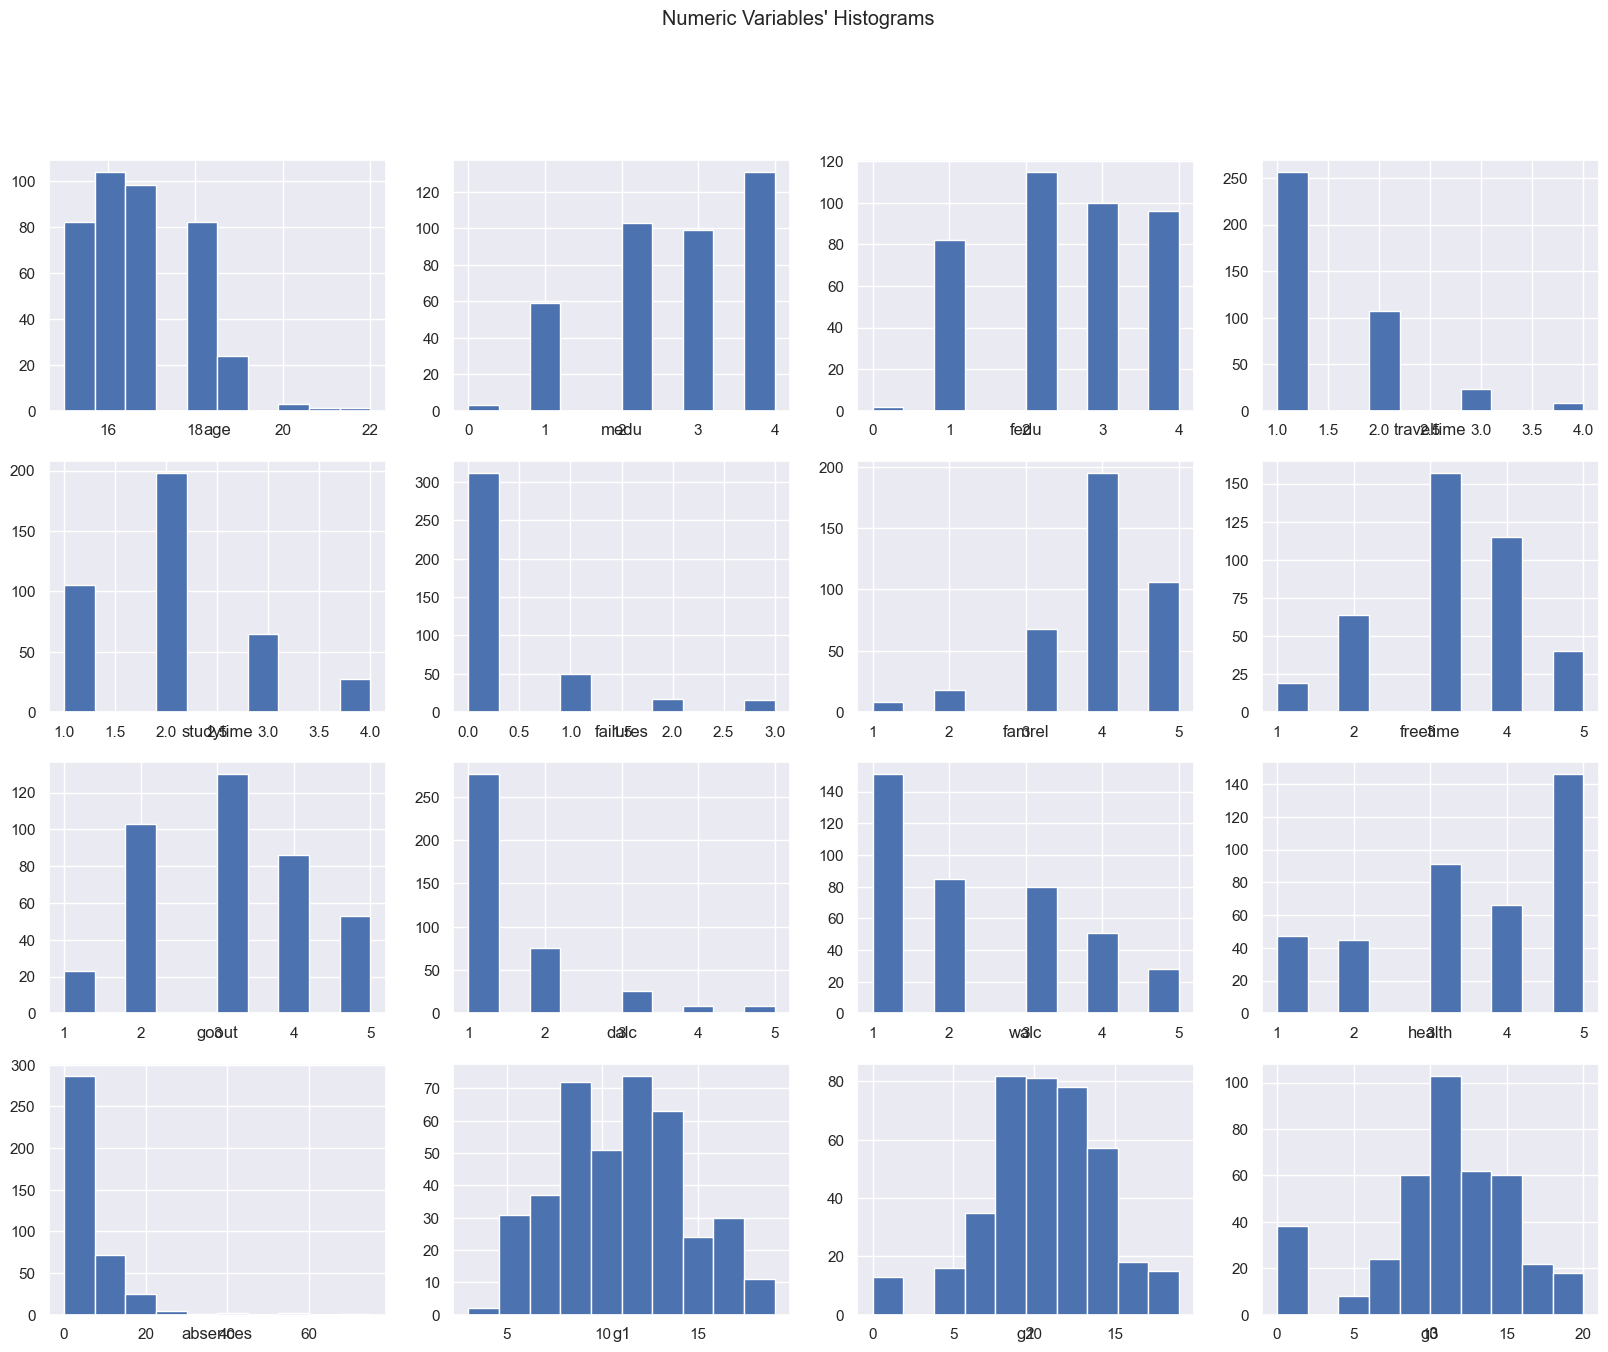

In [14]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(4, ceil(len(numerical) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

Text(0.5, 0.98, "Numeric Variables' Box Plots")

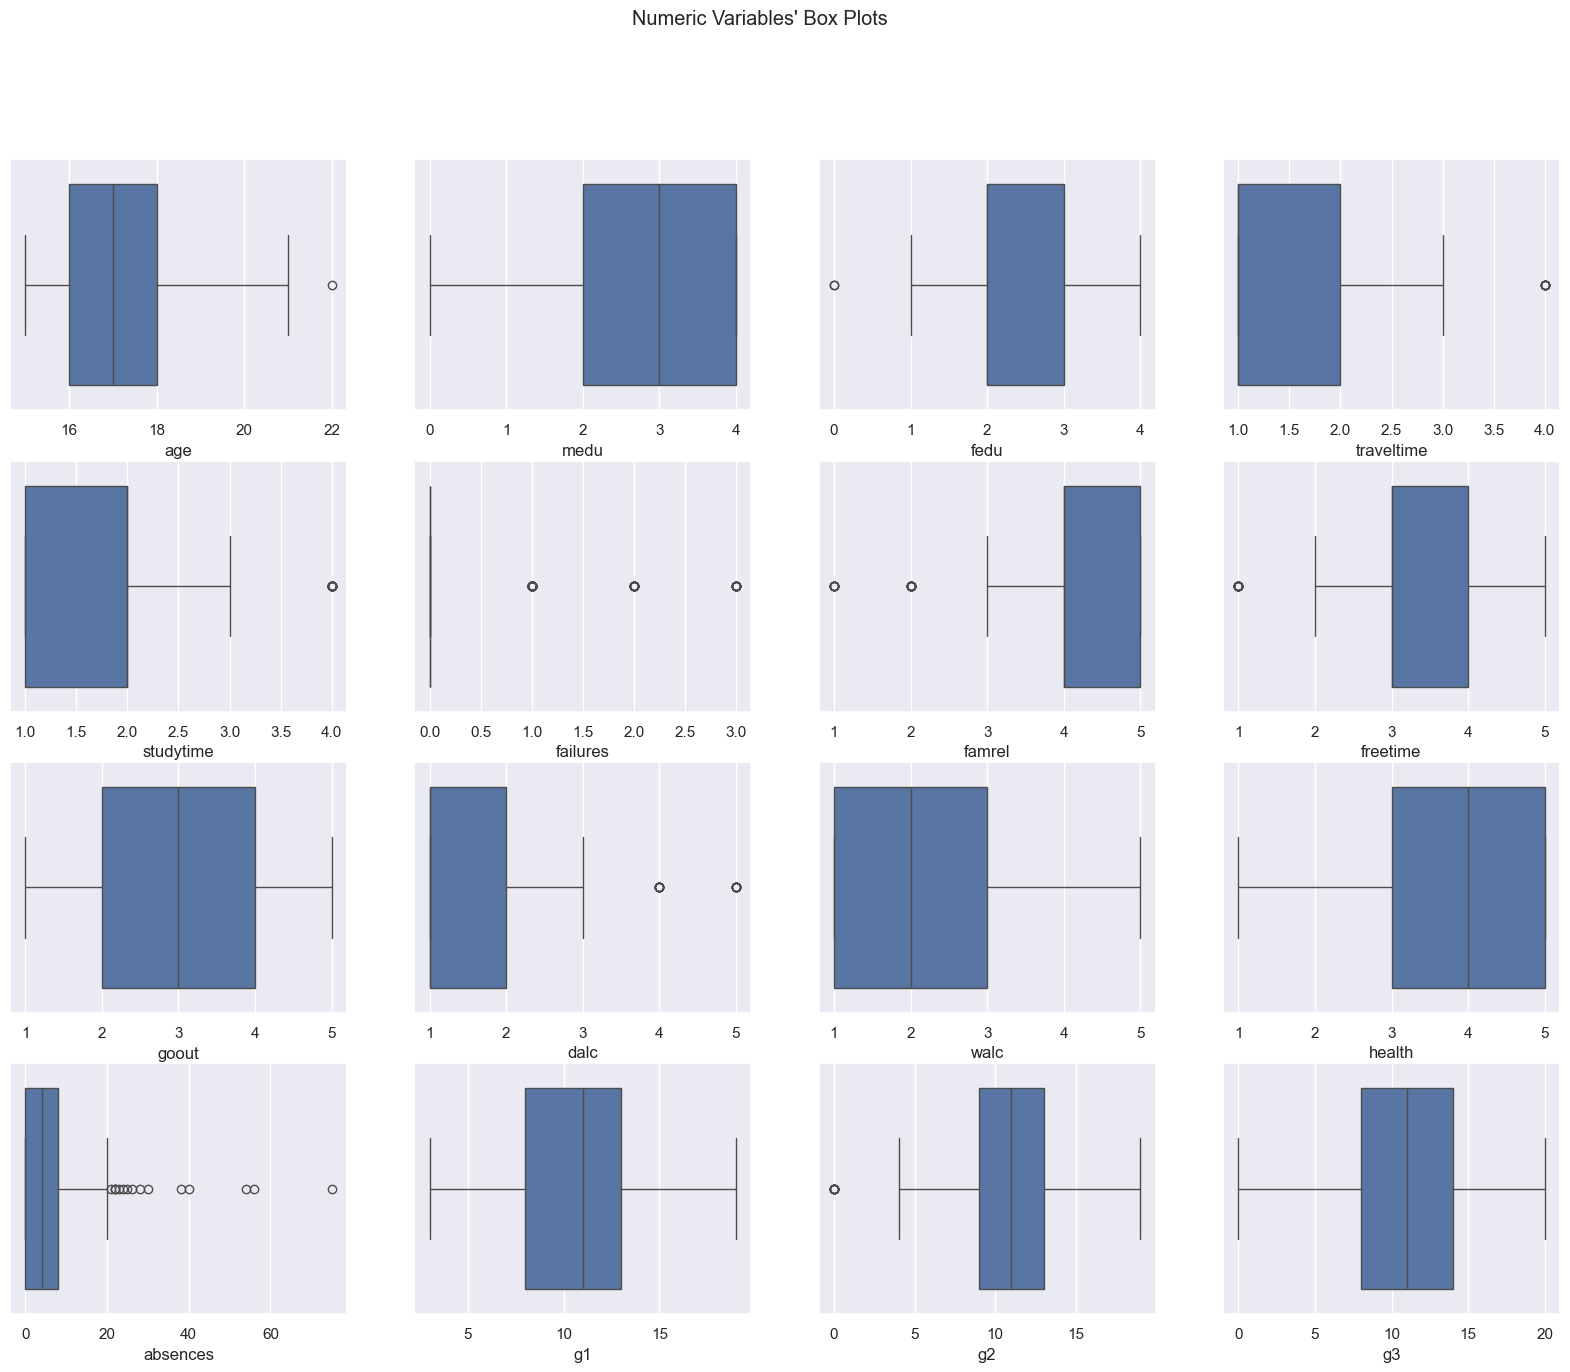

In [15]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(4, ceil(len(numerical) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

Text(0.5, 0.98, "Categorical/Low Cardinality Variables' Absolute Frequencies")

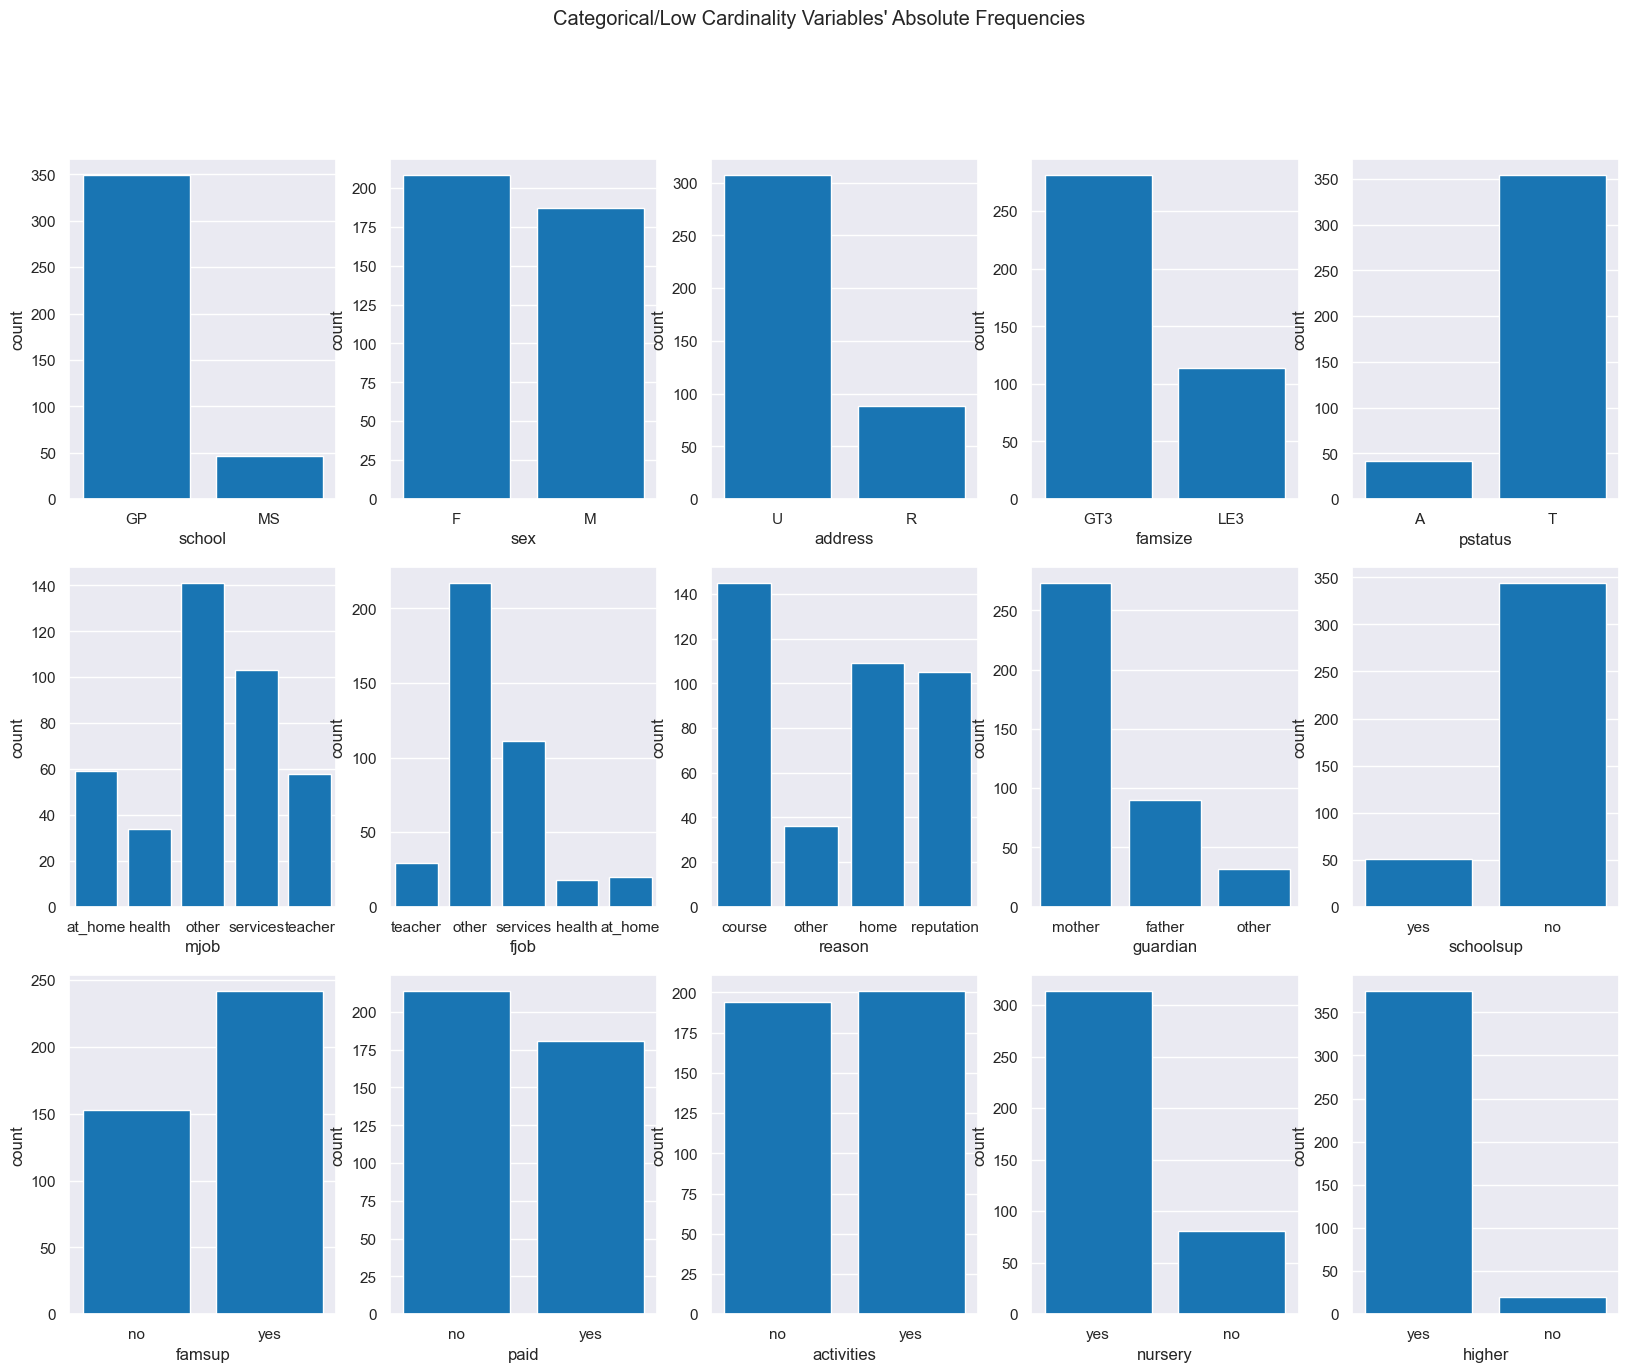

In [16]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(3, ceil(len(categorical) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), categorical): # Notice the zip() function and flatten() method
    sns.countplot(x = df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

# 2. Feature importance: Mutual information

In [17]:
def mutual_info_g3(series):
    return mutual_info_score(series, df.g3)

In [18]:
mi = df[categorical].apply(mutual_info_g3)
mi.sort_values(ascending=False)

mjob          0.112001
fjob          0.094754
reason        0.068820
schoolsup     0.046234
romantic      0.042337
paid          0.040313
guardian      0.037961
higher        0.035951
address       0.031603
sex           0.027669
internet      0.027266
nursery       0.023622
famsize       0.022291
activities    0.020910
pstatus       0.020165
famsup        0.019123
school        0.017209
dtype: float64

In [19]:
def cor_heatmap(cor):
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.2')
    plt.figure(figsize=(5,5))
    plt.show()

In [20]:
# Correlation with Pearson method
cor_pearson = df[numerical].corr(method ='pearson')

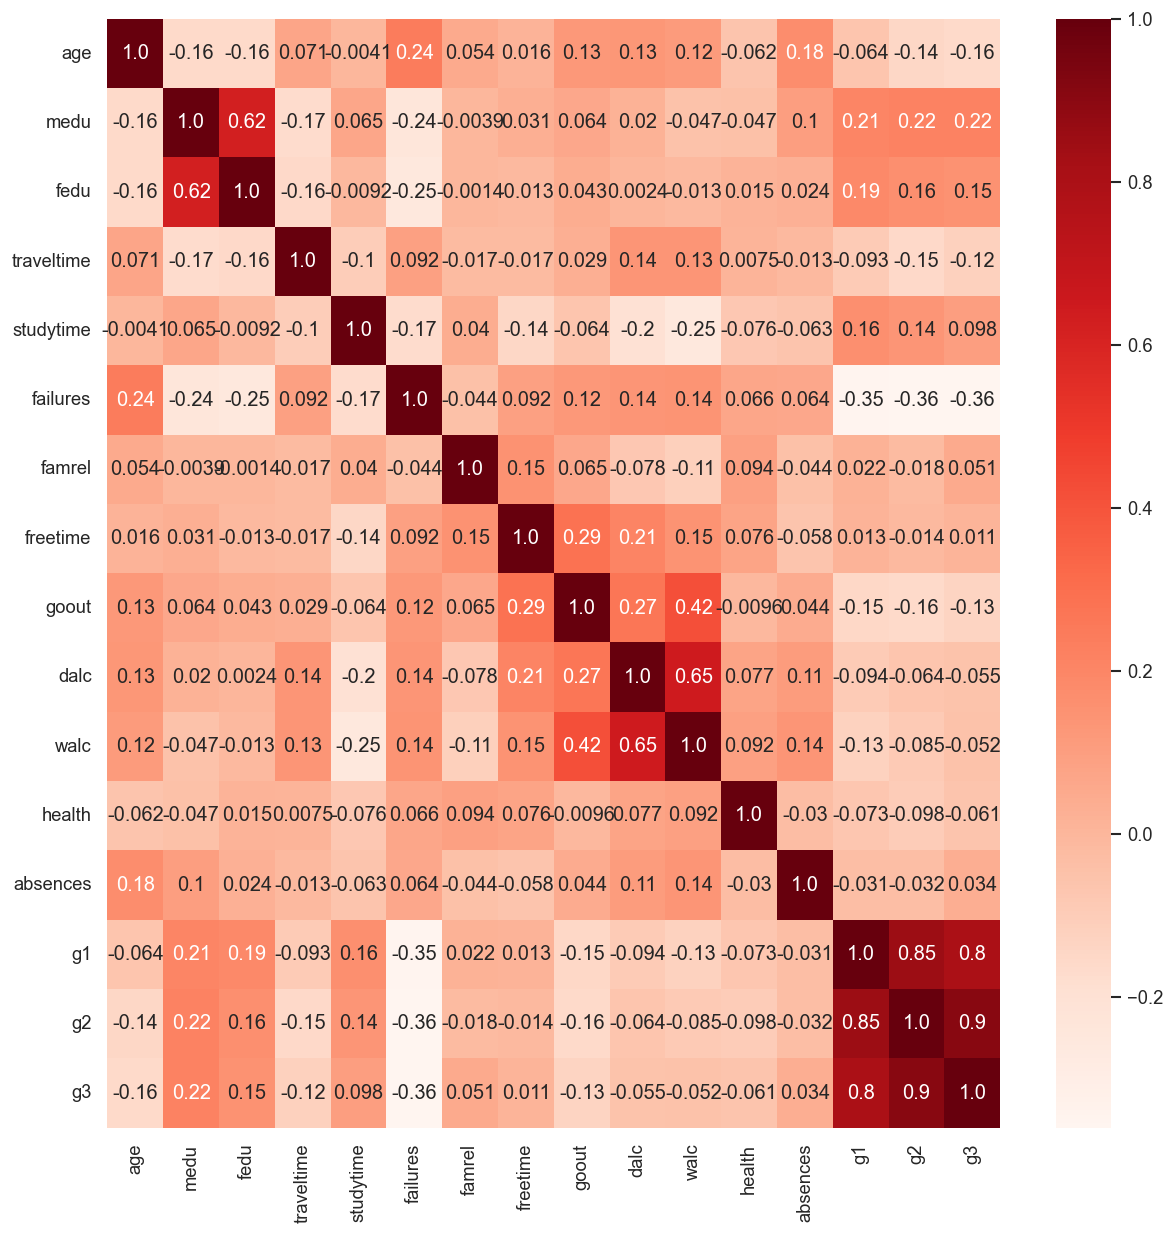

<Figure size 500x500 with 0 Axes>

In [21]:
# Spearman correlation heatmap
fig = plt.figure(figsize=(12,12), dpi = 120)
cor_heatmap(cor_pearson)

## 3. Setting up the validation framework

In [22]:
# Perform the train/validation/test split with Scikit-Learn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [23]:
len(df_train), len(df_val), len(df_test)

(237, 79, 79)

In [24]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [25]:
y_train = df_train.g3.values
y_val = df_val.g3.values
y_test = df_test.g3.values

del df_train['g3']
del df_val['g3']
del df_test['g3']

## 4. Linear Regression

In [26]:
# Create linear regression object
lr = LinearRegression()

In [27]:
numerical.remove("g3")

In [28]:
# Train the model using the training sets
lr.fit(df_train[numerical], y_train)

LinearRegression()

In [29]:
# Make predictions using the validation set
y_pred = lr.predict(df_val[numerical])

In [30]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [31]:
rmse(y_val, y_pred)

2.1958573681499747

## 5. Ridge Regression

In [32]:
ridge = Ridge()

In [33]:
# Train the model using the training sets
ridge.fit(df_train[numerical], y_train)

Ridge()

In [34]:
# Make predictions using the validation set
y_pred = ridge.predict(df_val[numerical])

In [35]:
rmse(y_val, y_pred)

2.1955794503143164

In [36]:
# Tuning hyperparameter alpha for Ridge Regression

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}  # Try different values for alpha

# GridSearchCV to tune the alpha hyperparameter, using RMSE as the scoring metric
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error')  
grid_search.fit(df_train[numerical], y_train)

# Check if fitting was successful and if results are available
if hasattr(grid_search, 'cv_results_'):
    # Print the results for each alpha value
    for mean_score, std_dev, params in zip(grid_search.cv_results_['mean_test_score'], 
                                           grid_search.cv_results_['std_test_score'], 
                                           grid_search.cv_results_['params']):
        print(f"Alpha: {params['alpha']} -> Mean RMSE: {-mean_score:.4f} ± {std_dev:.4f}")

Alpha: 0.001 -> Mean RMSE: 1.8927 ± 0.4538
Alpha: 0.01 -> Mean RMSE: 1.8927 ± 0.4538
Alpha: 0.1 -> Mean RMSE: 1.8926 ± 0.4539
Alpha: 1 -> Mean RMSE: 1.8913 ± 0.4542
Alpha: 10 -> Mean RMSE: 1.8807 ± 0.4570
Alpha: 100 -> Mean RMSE: 1.8512 ± 0.4683
Alpha: 1000 -> Mean RMSE: 2.0380 ± 0.5018


In [37]:
ridge = Ridge(alpha=100)

In [38]:
ridge.fit(df_train[numerical], y_train)

Ridge(alpha=100)

In [39]:
y_pred = ridge.predict(df_val[numerical])
rmse(y_val, y_pred)

2.191653448291028

## 6. Logistic Regression

In [40]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [41]:
model = LogisticRegression(solver='lbfgs', max_iter = 10000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [42]:
# Make predictions using the validation set
y_pred = model.predict(X_val)

In [43]:
rmse(y_val, y_pred)

2.1758164479546234

In [44]:
## Feature scaling + OHE

In [45]:
X_train_numerical = df_train[numerical].values

scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train_numerical = scaler.fit_transform(X_train_numerical)

In [46]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [47]:
X_train_categorical = ohe.fit_transform(df_train[categorical].values)

In [48]:
ohe.get_feature_names_out()

array(['x0_GP', 'x0_MS', 'x1_F', 'x1_M', 'x2_R', 'x2_U', 'x3_GT3',
       'x3_LE3', 'x4_A', 'x4_T', 'x5_at_home', 'x5_health', 'x5_other',
       'x5_services', 'x5_teacher', 'x6_at_home', 'x6_health', 'x6_other',
       'x6_services', 'x6_teacher', 'x7_course', 'x7_home', 'x7_other',
       'x7_reputation', 'x8_father', 'x8_mother', 'x8_other', 'x9_no',
       'x9_yes', 'x10_no', 'x10_yes', 'x11_no', 'x11_yes', 'x12_no',
       'x12_yes', 'x13_no', 'x13_yes', 'x14_no', 'x14_yes', 'x15_no',
       'x15_yes', 'x16_no', 'x16_yes'], dtype=object)

In [49]:
# Combining two matrices into one - `X_train`
X_train = np.column_stack([X_train_numerical, X_train_categorical])

In [50]:
model = LogisticRegression(solver='lbfgs', C=1.0, random_state=42, max_iter=5000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=5000, random_state=42)

In [51]:
X_val_numerical = df_val[numerical].values
X_val_numerical = scaler.transform(X_val_numerical)

X_val_categorical = ohe.transform(df_val[categorical].values)

X_val = np.column_stack([X_val_numerical, X_val_categorical])

In [52]:
# Make predictions using the validation set
y_pred = model.predict(X_val)

In [53]:
rmse(y_val, y_pred)

3.310894941923663

In [54]:
#Scaling worsened result, I will return to the original dataframe and do Cross-Validation
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [55]:
# Cross-Validation
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='lbfgs', C=C, max_iter=15000)
    model.fit(X_train, y_train)
    
    return dv, model

In [56]:
dv, model = train(df_train, y_train, C=1.0)

In [57]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict(X)

    return y_pred

In [58]:
y_pred = predict(df_val, dv, model)

In [59]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.g3.values
        y_val = df_val.g3.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        rmse_value = rmse(y_val, y_pred)
        scores.append(rmse_value)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 4.074 +- 0.770
C=0.01 3.053 +- 0.546
C=0.1 2.504 +- 0.362
C=0.5 2.467 +- 0.461
C=1 2.400 +- 0.615
C=5 2.517 +- 0.561
C=10 2.528 +- 0.529


In [60]:
scores

[2.6309456474811483,
 2.0158105227158787,
 3.172300752370756,
 2.9947043206724047,
 1.8257418583505538]

In [61]:
dv, model = train(df_train, df_train.g3, C=1.0)
y_pred = predict(df_val, dv, model)

rmse(y_val, y_pred)

1.6232438618151726

## 7. Decison Tree

In [63]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [64]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [65]:
y_pred = dt.predict(X_val)

In [66]:
rmse(y_val, y_pred)

1.4029447488244033

In [67]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    rmse_value = rmse(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, rmse_value))

   1 -> 3.252
   2 -> 2.448
   3 -> 1.784
   4 -> 1.818
   5 -> 1.557
   6 -> 1.708
  10 -> 1.704
  15 -> 1.420
  20 -> 1.363
None -> 1.357


In [68]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse_value = rmse(y_val, y_pred)
        
        scores.append((depth, s, rmse_value))

In [69]:
columns = ['max_depth', 'min_samples_leaf', 'rmse_value']
df_scores = pd.DataFrame(scores, columns=columns)

In [70]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse_value'])
df_scores_pivot.round(3)

rmse_value              
max_depth                 4      5      6
min_samples_leaf                         
1                     1.818  1.555  1.693
5                     1.796  1.600  1.505
10                    1.345  1.319  1.313
15                    1.392  1.365  1.367
20                    1.800  1.816  1.816
100                   3.252  3.252  3.252
200                   5.023  5.023  5.023
500                   5.023  5.023  5.023

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

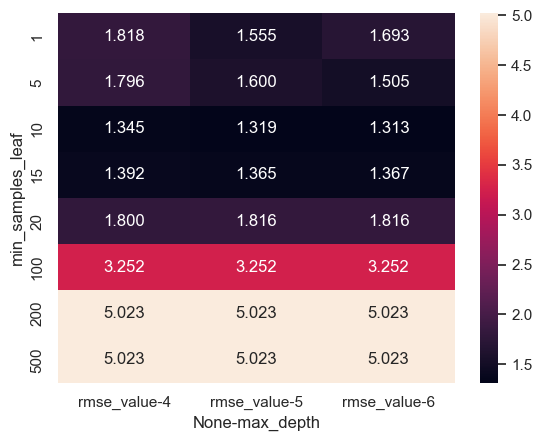

In [71]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [72]:
dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=10)

In [73]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- g2 <= 10.50
|   |--- g2 <= 5.50
|   |   |--- g2 <= 2.00
|   |   |   |--- value: [0.00]
|   |   |--- g2 >  2.00
|   |   |   |--- value: [3.30]
|   |--- g2 >  5.50
|   |   |--- absences <= 1.00
|   |   |   |--- age <= 16.50
|   |   |   |   |--- value: [7.87]
|   |   |   |--- age >  16.50
|   |   |   |   |--- value: [3.33]
|   |   |--- absences >  1.00
|   |   |   |--- g2 <= 7.50
|   |   |   |   |--- value: [6.88]
|   |   |   |--- g2 >  7.50
|   |   |   |   |--- g2 <= 9.50
|   |   |   |   |   |--- g2 <= 8.50
|   |   |   |   |   |   |--- value: [8.38]
|   |   |   |   |   |--- g2 >  8.50
|   |   |   |   |   |   |--- value: [9.21]
|   |   |   |   |--- g2 >  9.50
|   |   |   |   |   |--- value: [10.31]
|--- g2 >  10.50
|   |--- g2 <= 13.50
|   |   |--- g2 <= 12.50
|   |   |   |--- g1 <= 11.50
|   |   |   |   |--- value: [11.21]
|   |   |   |--- g1 >  11.50
|   |   |   |   |--- sex=M <= 0.50
|   |   |   |   |   |--- value: [11.90]
|   |   |   |   |--- sex=M >  0.50
|   |   |   |   |   |--

In [74]:
y_pred = dt.predict(X_val)

In [75]:
rmse(y_val, y_pred)

1.3134677813868294

## 8. Random Forest

In [76]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_value = rmse(y_val, y_pred)

        scores.append((d, n, rmse_value))

In [77]:
columns = ['max_depth', 'n_estimators', 'rmse_value']
df_scores = pd.DataFrame(scores, columns=columns)

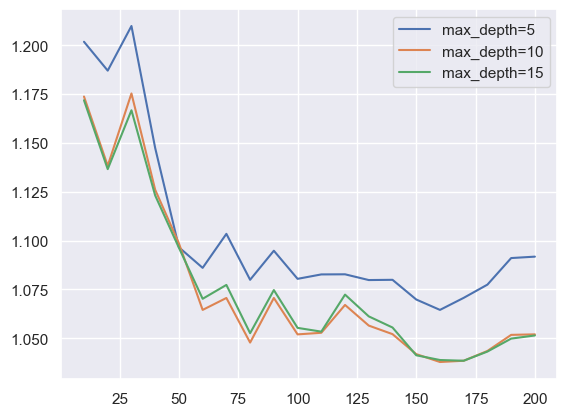

In [78]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse_value,
             label='max_depth=%d' % d)

plt.legend()

In [79]:
max_depth = 5

In [80]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_value = rmse(y_val, y_pred)

        scores.append((s, n, rmse_value))

In [81]:
columns = ['min_samples_leaf', 'n_estimators', 'rmse_value']
df_scores = pd.DataFrame(scores, columns=columns)

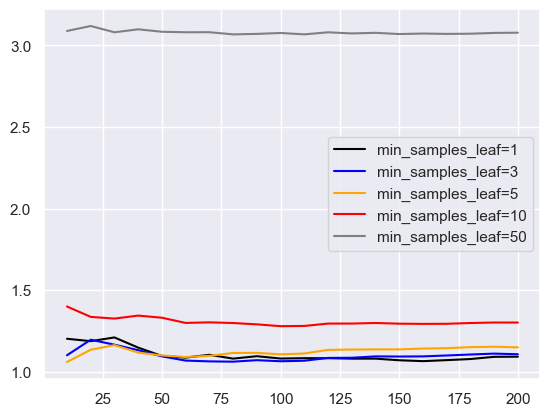

In [82]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse_value,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [83]:
min_samples_leaf = 10

In [84]:
rf = RandomForestRegressor(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=10, n_estimators=200,
                      random_state=1)

In [85]:
y_pred = rf.predict(X_val)

In [86]:
rmse(y_val, y_pred)

1.3011700861877957

## 9. Gradient boosting and XGBoost

In [297]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [298]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [299]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
        
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [300]:
y_pred = model.predict(dval)

In [301]:
rmse(y_val, y_pred)

0.9386794166366101

In [302]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [303]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
        
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [304]:
s = output.stdout

In [305]:
print(s[:200])

[0]	train-rmse:3.46619	val-rmse:3.58558
[5]	train-rmse:0.93582	val-rmse:1.14443
[10]	train-rmse:0.34391	val-rmse:0.90409
[15]	train-rmse:0.17357	val-rmse:0.89139
[20]	train-rmse:0.09943	val-rmse:0.884


In [306]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [307]:
df_score = parse_xgb_output(output)

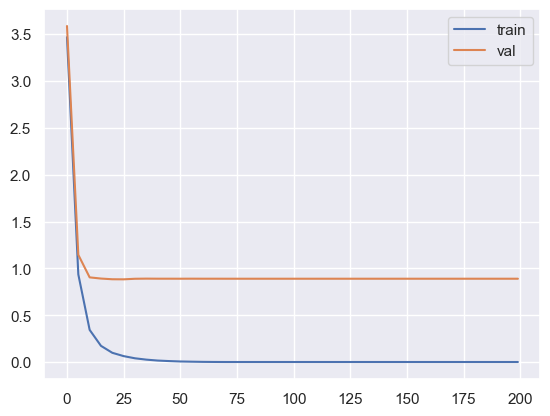

In [308]:
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

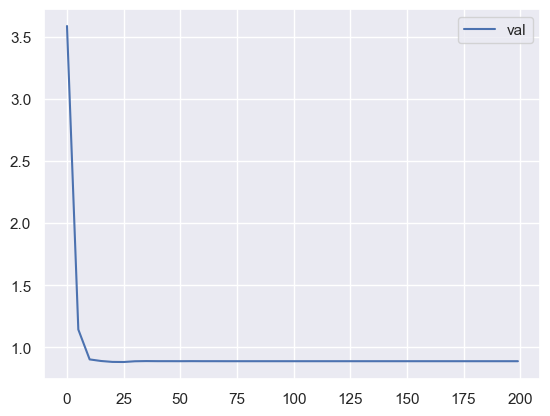

In [309]:
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
plt.legend()

In [310]:
# XGBoost parameter tuning
# Tuning the following parameters:
# eta
# max_depth
# min_child_weight

In [311]:
etas = [0.01, 0.05, 0.1, 0.3, 0.9, 1.0]

In [312]:
scores = {}  # Dictionary to store results for each eta

for eta in etas:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Train the model
    output = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=output,  # Capture evaluation results
                      verbose_eval=False)
    
    # Store RMSE values for the validation set
    scores[eta] = output['val']['rmse']  

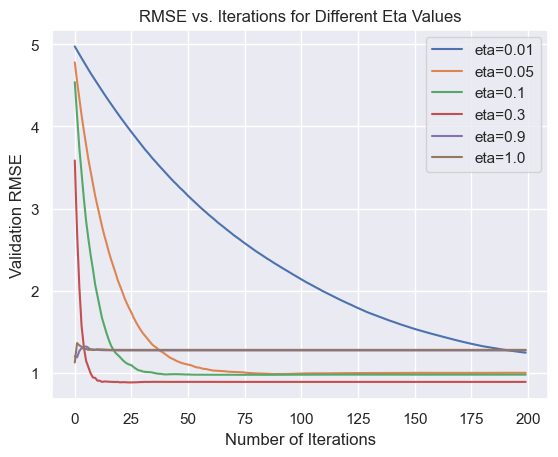

In [313]:
for eta, rmse_values in scores.items():
    plt.plot(range(len(rmse_values)), rmse_values, label=f"eta={eta}")
    
plt.xlabel("Number of Iterations")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("RMSE vs. Iterations for Different Eta Values")
plt.show()

In [314]:
# Choosing eta =0.3 for further xgb tuning

In [315]:
max_depths = [3, 4, 5, 6, 10, 15, 20, 30]

In [316]:
scores = {}  # Dictionary to store results for each eta

for max_depth in max_depths:
    xgb_params = {
        'eta': 0.3,
        'max_depth': max_depth,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Train the model
    output = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=output,  # Capture evaluation results
                      verbose_eval=False)
    
    # Store RMSE values for the validation set
    scores[max_depth] = output['val']['rmse'] 

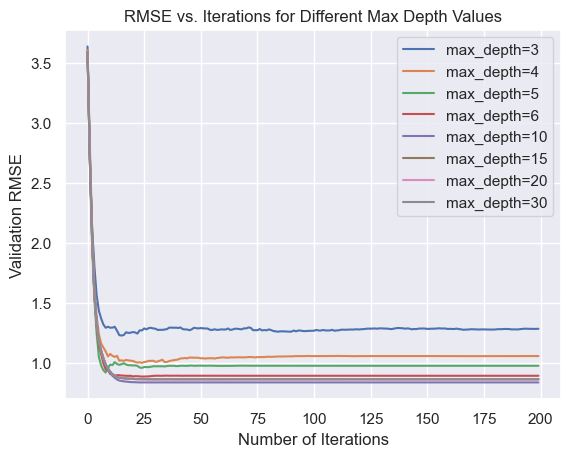

In [317]:
for max_depth, rmse_values in scores.items():
    plt.plot(range(len(rmse_values)), rmse_values, label=f"max_depth={max_depth}")
    
plt.xlabel("Number of Iterations")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("RMSE vs. Iterations for Different Max Depth Values")
plt.show()

In [318]:
min_child_weights = [1, 10, 20, 30, 50, 100]

In [319]:
scores = {}  # Dictionary to store results for each eta

for min_child_weight in min_child_weights:
    xgb_params = {
        'eta': 0.3,
        'max_depth': 10,
        'min_child_weight': min_child_weight,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
    # Train the model
    output = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=output,  # Capture evaluation results
                      verbose_eval=False)
    
    # Store RMSE values for the validation set
    scores[min_child_weight] = output['val']['rmse'] 

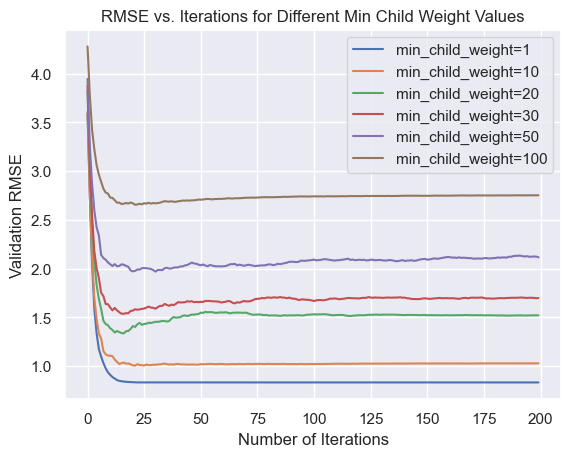

In [320]:
for min_child_weight, rmse_values in scores.items():
    plt.plot(range(len(rmse_values)), rmse_values, label=f"min_child_weight={min_child_weight}")
    
plt.xlabel("Number of Iterations")
plt.ylabel("Validation RMSE")
plt.legend()
plt.title("RMSE vs. Iterations for Different Min Child Weight Values")
plt.show()

In [321]:
# Training xgb model with the best parameters
xgb_params = {
        'eta': 0.3,
        'max_depth': 10,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }
    
# Train the model
output = {}
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      evals=watchlist,
                      evals_result=output,  # Capture evaluation results
                      verbose_eval=False)

In [322]:
y_pred = model.predict(dval)

In [323]:
rmse(y_val, y_pred)

0.8339724937040843

## 10. XGB Cross-Validation

In [324]:
# Cross-validation
cv_results = xgb.cv(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=5,  # Number of folds
    metrics="rmse",
    as_pandas=True,
    seed=1
)

In [325]:
# Print mean RMSE across folds for the best round
print(cv_results.iloc[-1])

train-rmse-mean    0.000562
train-rmse-std     0.000019
test-rmse-mean     2.086041
test-rmse-std      0.412521
Name: 99, dtype: float64


## 11. Selecting the final model

In [116]:
# The best result is achieved by XGB, and I will apply it for the final prediction

In [326]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [327]:
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

In [328]:
xgb_params = {
        'eta': 0.3,
        'max_depth': 10,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [329]:
y_pred = model.predict(dtest)

In [330]:
rmse(y_test, y_pred)

1.5609224430482218

## 12. Saving the model

In [331]:
import pickle

In [332]:
output_file = 'model.bin'

In [333]:
output_file

'model.bin'

In [334]:
f_out = open(output_file, 'wb')
pickle.dump((dv, model), f_out)
f_out.close()

In [335]:
with open(output_file, 'wb') as f_out: 
    pickle.dump((dv, model), f_out)

## 13. Loading the model

In [336]:
input_file = 'model.bin'

In [337]:
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [338]:
model